# Framing the problem



***how can the predictive model be used to improve business performance?***
---

>After some research some of the usecases of predictive modeling are:



| Usecase                                 	| Bussiness improvement                                                 	|
|-----------------------------------------	|-----------------------------------------------------------------------	|
| Predict customers’ behavior (churn/CLV) 	| Improves retention by targeting the right message to the right users  	|
| Lead scoring                            	| Improves the ROI of activation campaings                              	|
| Recommendation                          	| Improves ARPU  by upsell and cross-sell                               	|
| Personalisation                         	| Improves retention by a better experience                             	|
| Customer segmentation                   	| Improves the ROI of retention campaings                               	|
| Chatbots                                	| Reduces Customer experience costs                                     	|

<br>

[Source 1](https://medium.com/activewizards-machine-learning-company/top-8-data-science-use-cases-in-marketing-d62291ce62b6)

[Source 2](https://www.proxzar.ai/blog/top-8-use-cases-for-machine-learning-ai-in-marketing/)

<br>

---
<br>

> As suggested, the scope will be on the first case: *Predict customers’ behavior (churn/CLV)*

<br>

Having the scope defined, a more in depth research reveals:

**Bussiness benefits**
<br>

 - It allows marketers to prioritize aquisition efforts
 - Maximize the value of top customers
 - Develop a more customer-centric marketing strategy
 - Improve bidding of ad impressions


<br><br>




**Most common approach**
<br>
- This is a non-contractual and comtinuous purchases setting
- FRM features
- Beta Geometric/Negative Binomial Distribution Model combined with the Gamma-Gamma model
- There is a useful package called *lifetimes*

[Source 1](https://towardsdatascience.com/buy-til-you-die-predict-customer-lifetime-value-in-python-9701bfd4ddc0)

[Source 2](https://eng.amperity.com/posts/2019/12/predictive-clv)

[Source 3 - video](https://www.youtube.com/watch?v=gx6oHqpRgpY&ab_channel=PyData)

<br><br>
**Alternative approach**
<br>

- Deep learning with a custom loss function (ZILN Loss)

[Source 1](https://towardsdatascience.com/the-paper-a-deep-probabilistic-model-for-customer-lifetime-value-prediction-eb5d61a83ecd)

[Source 2](https://arxiv.org/pdf/1912.07753.pdf)













# Imports

In [136]:
# export

#installs
%pip install pycaret --quiet
%pip install lifetimes --quiet
%pip install gdown --quiet
%pip install zipfile --quiet
# !conda install scikit-learn=0.23.2 -y
#%pip freeze -> requirements.txt


# imports
from datetime import timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
sns.set_context("notebook")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.cluster import KMeans
from sklearn import model_selection

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path




# Get the data

In [137]:
#export

#package all into a function
def get_data(file_id):
    
    import os
    if not os.path.exists('data'):
        os.makedirs('data')
    
    import gdown
    url = f'https://drive.google.com/uc?id={file_id}'
    zip_file = 'data/data.zip'
    gdown.download(url, zip_file, quiet=False)
    
    import  zipfile
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('data/unzipped_data')

    users_raw = pd.read_csv('data/unzipped_data/nsds_users.csv')
    purchases_raw = pd.read_csv('data/unzipped_data/nsds_purchases.csv')

    return  users_raw, purchases_raw

In [138]:
users_raw, purchases_raw= get_data('1TwngwmdW1qMmRvZOYrWf2bXSP40CSJC_')

In [139]:
# Simple scrip to move usefull code to a module
#!python ./notebook2script.py 00_brds.ipynb

# EDA

## Purchases

In [140]:
purchases_raw.info()

In [141]:
purchases_raw.head()

In [142]:
#dates types
purchases = purchases_raw.copy()
purchases['purchased_at'] = pd.to_datetime(purchases_raw['purchased_at'])
purchases['purchase_date'] = purchases.purchased_at.dt.date

In [143]:
print(f"There are {purchases.user_id.nunique()} users with at least 1 purchase")
print(f"{purchases.user_id.nunique() / users_raw.user_id.nunique()} of the total")

### User distribution

In [144]:
plot_df = purchases.groupby(['user_id']).agg(purchases=('user_id', 'count')).reset_index()

fig = px.histogram(plot_df, x='purchases', title='purchases by user')
fig.show()

fig = px.box(plot_df, x='purchases', title='purchases by user')
fig.show()

plot_df = (purchases.groupby('user_id').agg(purchases=('user_id', 'count')).value_counts()).reset_index().rename(columns={0:'users'})
plot_df['agg_percent_users'] = plot_df.users.sort_values(ascending=False).cumsum()/purchases.user_id.nunique()
fig = px.bar(plot_df, x='purchases', y='agg_percent_users')
fig.update_layout(title_text='% or users vs number of purchases',
                  yaxis_title="agg_percent_users")
fig.show()

50% of the users with a purchase are one-offs<br>
And there are some outliers

### Volume of sales

In [145]:
plot_df = purchases.groupby(['purchase_date']).agg(purchases=('user_id', 'count'))
fig = px.line(plot_df)
fig.update_layout(title_text='purchases by date',
                  yaxis_title="Sales")
fig.show()
print("Dates with peaks: (there is a peak in the last day of feb that falls into different dates)")
plot_df[plot_df.purchases>300].reset_index().purchase_date.pipe(pd.to_datetime).dt.strftime('%d/%m').value_counts()

### Volume by product

In [146]:
plot_df = purchases.groupby(['purchase_date', 'product', 'product2']).agg(purchases=('user_id', 'count')).reset_index()
fig = px.line(plot_df, x='purchase_date', y='purchases', facet_row='product', facet_col='product2' )
fig.update_layout(title_text='purchases by date',
                  yaxis_title="purchases", height=1200 )

fig.show()

### Value by product

In [147]:
plot_df = purchases.groupby(['purchase_date', 'product', 'product2']).agg(mean_value=('value', 'mean')).reset_index()
fig = px.line(plot_df, x='purchase_date', y='mean_value', facet_row='product', facet_col='product2', height=1200 )
fig.update_layout(title_text='mean value of products by date',
                  yaxis_title="mean value")
fig.show()

print(" The peack in sales of the 08/10 was because of a marketing action. Could be useful to meassure price elasticity")

In [148]:
fig = px.histogram(purchases, x='value')
fig.update_layout(title_text='mean value of products by date',
                  yaxis_title="mean value")
fig.show()

In [149]:
plot_df = purchases.groupby(['product', 'product2']).agg(purchases=('user_id', 'count')).reset_index()

plot_df['prod'] = plot_df['product'].astype(str).str.cat(plot_df['product2'].astype(str), sep='-')
fig = px.pie(plot_df, values='purchases', names='prod' , title='purchase share by product')
fig.show()

In [150]:
plot_df = purchases.groupby(['user_id', 'purchase_date']).agg(purchases=('user_id', 'count')).reset_index()
plot_df['agg_purchases'] = plot_df.groupby('user_id')['purchases'].cumsum().reset_index(level=0, drop=True)
plot_df = plot_df.pivot(index='user_id', columns='purchase_date', values='agg_purchases')

plot_df = plot_df.loc[:,plot_df.columns>pd.to_datetime('2021-01-01')]
plot_df = plot_df.loc[plot_df.notna().any(axis=1),:]

fig = px.imshow(plot_df,  color_continuous_scale='Bluered', height=700)
fig.show()

## Retention

In [151]:
plot_df = pd.DataFrame({'purchase_month': purchases.purchase_date + pd.offsets.MonthBegin(-1),
                        'user_id': purchases.user_id
                       })

plot_df['first_purchase_month'] = plot_df.groupby('user_id').purchase_month.transform(np.min)
plot_df['months'] = (plot_df['purchase_month'] - plot_df['first_purchase_month'])// np.timedelta64(1, 'M')

plot_df = (plot_df.groupby(['first_purchase_month','months']).user_id.nunique().unstack().T\
/plot_df.groupby(['first_purchase_month','months']).user_id.nunique().unstack()[0])

fig = px.line(plot_df.iloc[:12, -12:])
fig.update_layout(title_text='Retention by cohort',
                  yaxis_title="% of Users")
fig.show()


For all the cohorts retention is about 0.05%

## Users

In [152]:
users_raw.info()

There are more columns than the documentation. In particular: feature,  month,bd_delta,  purchase_90_n, purchase_90_bin, x, intramonth, temp

I will stick to the columns in the documentation for now.<br>
And later include them as an alternative.
As a hypo purchase_90_n could be the purchases in a period outside the available data. (will deal with it in the end)

In [153]:
list(users_raw.columns)

In [154]:
users_num_features = ['birthyear', 'dx_0', 'dx_1', 'dx_2', 'dx_3', 'gx', 'im']
users_cat_features = ['gender', 'maildomain', 'region', 'orig_1', 'orig_2', 'utm_src', 'utm_med', 'utm_cpg', 'channel']
#we will not take is_active to train the model as it may have information of the value that is being predicted

users = users_raw[['user_id', 'created_at'] + users_cat_features + users_num_features]

def timify_(df, cols):
    for c in cols: df[c]= pd.to_datetime(df[c])
    return df

def categorify_(df, cols):
    for c in cols: df[c]= df[c].astype('object')
    return df




users = users.pipe(timify_ , cols=['created_at'])
users = users.pipe(categorify_ , cols=users_cat_features)

In [155]:
users.head()

In [156]:
# 100K users
users.shape

In [157]:
# Checking null values
plot_df = users.isna().mean()

fig = px.bar(plot_df, text_auto=True)
fig.update_layout(title_text='Percentage of nulls', yaxis=dict(tickformat=".2%"))
fig.show()

print("""
Gender feature is 94% empty
""")


### Cohort volumes

In [158]:
### add to pipeline
users['created_at'] = pd.to_datetime(np.where(users.created_at>pd.Timestamp.today(), pd.NaT, users.created_at))

In [159]:
plot_df = users.groupby(users.created_at.dt.strftime('%Y-%m'))[['user_id']].count()

fig = px.bar(plot_df, text_auto=True)
fig.update_layout(title_text='Users by cohort month',
                  yaxis_title="Users",)
fig.show()

In [160]:
### add to pipeline
users['birthyear'] = np.where(users.birthyear.between(pd.Timestamp.today().year - 90, pd.Timestamp.today().year - 15), users.birthyear, np.nan )

In [161]:
plot_df = users.groupby('birthyear')[['user_id']].count()

fig = px.bar(plot_df, text_auto=True)
fig.update_layout(title_text='Users by birthyear',
                  yaxis_title="Users",)
fig.show()

In [162]:
# maildomain distribution

plot_df = (users.maildomain.value_counts().cumsum()\
          /users.maildomain.value_counts().sum()).reset_index()

fig = px.line(plot_df, y='maildomain')
fig.update_layout(title_text='Acumulated users by distinct maildomain',
                  yaxis_title="% of Users")
fig.show()


print("""
The first 7 domains cover the 80% of the users
and the first 36 cover the 90% of the users
""")

In [163]:
# region distribution

plot_df = (users.region.value_counts().cumsum()\
          /users.region.value_counts().sum()).reset_index()

fig = px.line(plot_df, y='region')
fig.update_layout(title_text='Acumulated users by distinct region',
                  yaxis_title="% of Users")
fig.show()


print("""
The first 20 regions cover the 80% of the users
and the first 35 cover the 90% of the users
""")

In [164]:
fig = px.scatter_matrix(users[['dx_0',	'dx_1',	'dx_2',	'dx_3', 'im', 'gx']],
                        width=1200, height=800, opacity=0.6)
fig.show()
print("""
Numerical features look non correlated
""")

# Pre-process


The model will predict the revenue per user of the next 90 days. <br>
In order to train the model we will take the last 90 days of the purchases table and convert that data to the variable we are going to predict : 
<br>





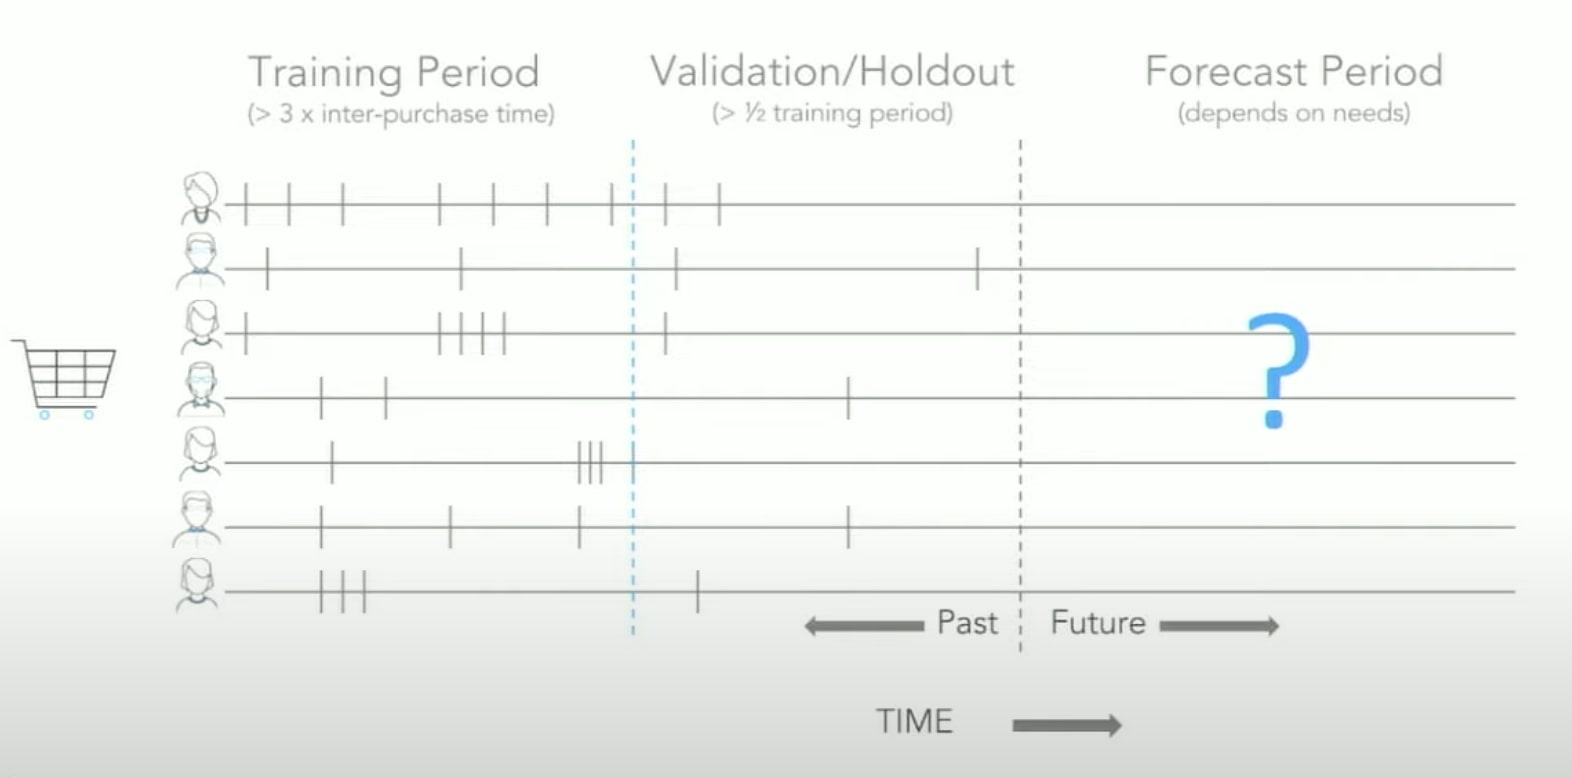

https://youtu.be/gx6oHqpRgpY?t=1046

### Split the purchases table

In [165]:
purchase_date = pd.to_datetime(purchases_raw.purchased_at).dt.date
created_date = pd.to_datetime(users_raw.created_at).dt.date

validation_from_date = purchase_date.max() - timedelta(days=90)

X_purchases_raw = purchases_raw[purchase_date <  validation_from_date]
Y_purchases_raw = purchases_raw[purchase_date >= validation_from_date]

X_users_raw = users_raw[created_date <  validation_from_date]

### Preprocess pipeline

In [166]:
#export
class DataframeFunctionTransformer(BaseEstimator,TransformerMixin):
    """Creates a pandas Dataframe transformer from a function"""
    def __init__(self, func, **func_params):
        self.func = func
        self.func_params = func_params

    def transform(self, input_df, **transform_params):
        return self.func(input_df.copy(), **self.func_params)

    def fit(self, X, y=None, **fit_params):
        return self

In [167]:
#export
def select_columns_(df, cols=None):
    return df[cols]

def timify_(df, cols):
    for c in cols: df[c]= pd.to_datetime(df[c])
    return df

def add_date_(df, cols):
    for c in cols: df[f'{c}_date']= pd.to_datetime(df[c]).dt.date
    return df

def categorify_(df, cols):
    for c in cols: df[c]= df[c].astype('object')
    return df

def purchases_to_rfm_(df):
    """
    wrapper to the function summary_data_from_transaction_data
    https://github.com/CamDavidsonPilon/lifetimes/blob/0a0a84fe4b10fff0bdaa6a6020d930c8dc6aee2d/lifetimes/utils.py#L230
    """
    first_last_purchase_date = df.groupby('user_id').agg(first_purchase_date=('purchased_at_date','min'),
                                                         last_purchase_date=('purchased_at_date','max'),
                                                        ).reset_index()
    
    from lifetimes.utils import  summary_data_from_transaction_data
    frm_data = summary_data_from_transaction_data(
                                transactions = df, 
                                customer_id_col = "user_id", 
                                datetime_col = "purchased_at_date",
                                monetary_value_col = "value", 
                                freq = "D").reset_index()
    return frm_data.merge(first_last_purchase_date, how='left', on='user_id')
                                


In [168]:
#export
class FramesLeftMerger(BaseEstimator,TransformerMixin):
    """Creates a pandas Dataframe from a two pipelines and left joins them"""
    def __init__(self, pipe1, pipe2):
        self.pipe1 = pipe1
        self.pipe2 = pipe2

    def fit(self,X,y=None):
        return self

    def transform(self,X,y=None):
        df1, df2 = X[0], X[1]
        df1 = self.pipe1.fit_transform(df1.copy())
        df2 = self.pipe2.fit_transform(df2.copy())
        merge = df1.merge(df2, how='left', on='user_id')
        return merge

In [169]:
#export
preprocess_purchases = Pipeline(
    steps=[
        ("timify", DataframeFunctionTransformer(timify_ , cols=['purchased_at'])),
        ("add_date", DataframeFunctionTransformer(add_date_ , cols=['purchased_at'])),
        ("rfm", DataframeFunctionTransformer(purchases_to_rfm_)),
    ]
)


users_num_features = ['birthyear', 'dx_0', 'dx_1', 'dx_2', 'dx_3', 'gx', 'im']
users_cat_features = ['gender', 'maildomain', 'region', 'orig_1', 'orig_2', 'utm_src', 'utm_med', 'utm_cpg', 'channel']
select_cols = ['user_id', 'created_at'] + users_cat_features + users_num_features


preprocess_users = Pipeline(
    steps=[
        ("select_cols", DataframeFunctionTransformer(select_columns_ , cols=select_cols)),
        ("timify", DataframeFunctionTransformer(timify_ , cols=['created_at'])),
        ("categorify", DataframeFunctionTransformer(categorify_ , cols=users_cat_features)),

    ]
)



full_preprocess = FramesLeftMerger(preprocess_users, preprocess_purchases)

Now we have a pipeline that can ingest both files and return a dataframe with the rfm features

In [170]:
X = full_preprocess.fit_transform((X_users_raw, X_purchases_raw))
X.head()

In [171]:
train_full = Y_purchases_raw.groupby('user_id').agg(value_90=('value', 'sum'), purchases_90=('value', 'count')).reset_index()
train_full = X.merge(train_full, how='left', on='user_id')

bins = 4
train_full['value_90_bin'] = pd.qcut(train_full.value_90, bins, labels = [f'bin-{i+1}' for i in range(bins)])
train_full['value_90_bin'] = train_full['value_90_bin'].cat.add_categories('bin-0').fillna('bin-0')
train_full[['value_90', 'purchases_90']] = train_full[['value_90', 'purchases_90']].fillna(0)
train_full['purchases_90_bool'] = train_full['purchases_90']>0
train_full.head()


In [172]:
train_full.info()

# EDA 2

In [173]:
fig = px.box(train_full.sort_values(by='value_90_bin'), x='value_90', color='value_90_bin' )
fig.show()

In [205]:
fig = px.scatter_matrix(train_full[['frequency','recency','T','monetary_value', 'value_90_bin']],
                        width=1200, height=800, opacity=0.6, color='value_90_bin')
fig.show()

In [175]:
train_full

In [176]:
train_full.corr()['value_90']

# Extra features

Implementing the BetaGeo and GammaGamma statistical models as features

In [177]:
#export
class BetaGeoFitterTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.bgf = BetaGeoFitter(penalizer_coef=1e-06)

    def fit(self,X, y=None, **fit_params):
        self.bgf.fit(
            frequency = X["frequency"].fillna(0), 
            recency = X["recency"].fillna(0), 
            T = X["T"].fillna(0),   
            weights = None,  
            verbose = True,   
            tol = 1e-06)
        return self

    def transform(self,X, y=None,  **transform_params):
        X['bgf'] = self.bgf.conditional_expected_number_of_purchases_up_to_time(90, X["frequency"], X["recency"], X["T"])
        return X


class GammaGammaFitterTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.ggf = GammaGammaFitter(penalizer_coef = 1e-06)

    def fit(self,X, y=None, **fit_params):
        X_v = X[X.monetary_value>0]
        self.ggf.fit(
            frequency = X_v["frequency"],
            monetary_value = X_v["monetary_value"],  
            weights = None,  
            verbose = True,   
            tol = 1e-06)
        return self
    
    def transform(self,X, y=None,  **transform_params):
        preds= self.ggf.conditional_expected_average_profit(X["frequency"], X["monetary_value"])
        X.loc[X.monetary_value>0 , 'ggf'] = preds
        X['ggf'] = X['ggf'].fillna(0)
        return X



In [178]:
#export
def group_rare_categories(df, limit= 40, cols=None):
    df_c = df.copy()
    for c in cols:
        n = min(df_c[c].nunique() - 1, limit)
        df_c.loc[~df_c[c].isin( df_c[c].value_counts().iloc[:n].index ), c] = -1
    return df_c


def add_datepart(df, cols=None, drop=True, time=False, ):
    "Helper function that adds columns relevant to a date in the column `field_name` of `df`."
 
    import re
    for c in cols:
        #remove future dates
        df[c] =  pd.to_datetime(np.where(df[c]>pd.Timestamp.today(), pd.NaT, df[c]))
        field = df[c]
        prefix = re.sub('[Dd]ate$', '', c)
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
                'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time: attr = attr + ['Hour', 'Minute', 'Second']
        # Pandas removed `dt.week` in v1.1.10
        week = field.dt.isocalendar().week.astype(field.dt.day.dtype) if hasattr(field.dt, 'isocalendar') else field.dt.week
        for n in attr: df[prefix + n] = getattr(field.dt, n.lower()) if n != 'Week' else week
        mask = ~field.isna()
        df[prefix + 'Elapsed'] = np.where(mask,field.values.astype(np.int64) // 10 ** 9,np.nan)
        if drop: df.drop(c, axis=1, inplace=True)
    return df


    
def birthyear_filter(df, between=(15,90), cols=None):
    df_c = df.copy()
    for c in cols:
        df_c[c] = np.where(df_c[c].between(pd.Timestamp.today().year - between[1],pd.Timestamp.today().year - between[0]),
                           df_c[c],
                           np.nan )
    return df_c


In [179]:
#export
# cat_cols = X.select_dtypes(exclude="number").columns[1:]
cat_cols = ['gender', 'maildomain', 'region', 'orig_1', 'orig_2', 'utm_src','utm_med', 'utm_cpg', 'channel']
date_cols = ['created_at', 'first_purchase_date', 'last_purchase_date']

In [180]:
#export
extra_features_pipe = Pipeline(
    steps=[
            ("birthyear_filter", DataframeFunctionTransformer(birthyear_filter, cols=['birthyear'])),
            ("add_datepart", DataframeFunctionTransformer(add_datepart, cols=date_cols)),
            ("clean_categories", DataframeFunctionTransformer(group_rare_categories, cols=cat_cols)),
            ("betageo", BetaGeoFitterTransformer()), 
            ("gammagamma", GammaGammaFitterTransformer()),
           ]
)

In [181]:
train = extra_features_pipe.fit_transform(train_full)

In [182]:
train.corr()['value_90']

# Features to add:

- external data: covid cases, gdp of the respected countries, temperature

# Model - Predict value_90

In [183]:
train_regression = train.drop(columns=['purchases_90_bool', 'purchases_90', 'value_90_bin'])
train_regression.info()

In [184]:
from pycaret.regression import *

In [ ]:
# in jupyterlab
# %conda install xgboost
# %conda install lightbmg

In [185]:
exp = setup(
        data = train_regression,
        target = 'value_90',
        categorical_features = ['birthyear','maildomain', 'region', 'orig_1', 'orig_2', 'utm_src', 'utm_med', 'utm_cpg', 'channel',
                               'last_purchase_Year', 'last_purchase_Month', 'last_purchase_Week',
                                'first_purchase_Year', 'first_purchase_Month', 'first_purchase_Week',
                               'created_atYear', 'created_atMonth', 'created_atWeek' ],
        ignore_features=['user_id'],
        fold = 5,
        normalize=True,
        use_gpu=True,
        remove_outliers=True,
        polynomial_features=True,
        silent=True, 
      )

In [186]:
top4 = compare_models(sort='RMSE',n_select=4, include=['lightgbm', 'knn', 'omp', 'xgboost' ])

In [187]:
top4_tuned = [tune_model(m, n_iter=3) for m in top4]

### Best models are 'lightgbm', 'knn', 'omp', 'xgboost' <br>
And feature importances are different between models, it's possible to stack them to regularize results

In [188]:
plot_model(top4[0], 'feature')

In [189]:
plot_model(top4[1], 'feature')

In [190]:
plot_model(top4[3], 'feature')

In [191]:
plot_model(top4[0], 'residuals')

In [192]:
blended = blend_models(top4,optimize='RMSE', choose_better=True )

In [193]:
final = finalize_model(blended)

# Persist the model

In [194]:
#export
final_preprocess_pipeline = Pipeline(steps=[
    ('full_preprocess', full_preprocess),
    ('extra_features_pipe', extra_features_pipe),
])

In [195]:
model = final

In [196]:
import os
if not os.path.exists('model'): os.makedirs('model')
save_model(final, 'model/model_v4')

# Post process

In [197]:
preds = predict_model(model)

In [198]:
preds

In [199]:
preds.sort_values(by='Label', ascending=False)[:10]

There are negative predictions and a minimun price.
It's possible to set a threshold to the prediction.
Let's use 0.3

In [200]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)


x = [i/100 for i in range(50)]
y = [ smape(preds['value_90'], np.where(preds['Label']<i/100, 0, preds['Label'])) for i in range(50)]

fig = px.line(x=x,y=y)
fig.show()

In [201]:
#export
def label_postprocess(df, threshold=0.25, cols=None):
    df_c = df.copy()
    for c in cols:
        df_c[c] = np.where(df_c[c]<threshold, 0, df_c[c])
    return df_c


label_postprocess_transformer = DataframeFunctionTransformer(label_postprocess , cols=['Label'])

In [202]:
preds = label_postprocess_transformer.transform(preds)

fig = px.histogram(preds, x=['Label','value_90'], marginal="box")
fig.show()

fig = px.histogram(preds[(preds.value_90>0.1)&(preds['Label']>0.1)], x=['Label','value_90'], marginal="box")
fig.show()

In [203]:
predict_model(model, data=extra_features_pipe.transform(X))